In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
import math
import pandas as pd
import os
from copy import deepcopy

In [99]:
import sys
sys.path.insert(0, '/Users/karlhajjar/Documents/projects/wide-networks/')

from utils.plot.initialization.network import FCNetwork, define_networks, _rescale_init
from utils.plot.initialization.graphs import *
from utils.plot import set_plot_fonts

# Constants

In [4]:
from pytorch.initializers import INIT_DICT
INIT_DICT

{'glorot_uniform': <function torch.nn.init.xavier_uniform_(tensor, gain=1.0)>,
 'glorot_normal': <function torch.nn.init.xavier_normal_(tensor, gain=1.0)>,
 'normal': <function torch.nn.init.normal_(tensor, mean=0.0, std=1.0)>,
 'uniform': <function torch.nn.init.uniform_(tensor, a=0.0, b=1.0)>}

In [13]:
from pytorch.optimizers import OPT_DICT
OPT_DICT

{'adam': torch.optim.adam.Adam,
 'rmsprop': torch.optim.rmsprop.RMSprop,
 'sgd': torch.optim.sgd.SGD}

In [19]:
sigma = nn.ReLU()
d = 100  # dimension of the input data
n = int(1e3)  # number of samples considered

Ms = [50, 100, 200, 500, 1000, 2000, 5000]  #, 10000 , 20000, 50000
n_trials = 20
L = 3

x = 2 * torch.rand((n,d))
y = x.mean(axis=1)  # target for each sample is the mean over the d dimensions of the values of the components
batch_size = 256

figsize = (11,8)

figures_dir = '/Users/karlhajjar/Documents/projects/wide-networks/figures/initialization/training_bias_vs_no_bias/'

In [6]:
fonts_map = {'axes': {'titlesize': 20, 'labelsize': 18},
             'xtick': {'labelsize': 18},
             'ytick': {'labelsize': 18},
             'legend': {'fontsize': 16}}

set_plot_fonts(fonts_map)
sns.set_palette("deep")

# 1. Without bias

In [7]:
def set_random_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)

    # if you are using GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [8]:
set_random_seeds()

In [87]:
d = 50  # dimension of the input data
n = int(1e3)  # number of samples considered
n_test = int(1e2)
Ms = [50, 100, 500, 1000]  #, 10000 , 20000, 50000
n_trials = 1
x = 2 * torch.rand((n,d))
x_test = 2 * torch.rand((n_test, d))
y = x.mean(axis=1) 
y_test = x_test.mean(axis=1)

In [88]:
init = 'uniform'
init_params = {'a': -2.0, 'b': 2.0}
scaling = 'mf'
scale_init = None
bias = False

In [89]:
nets = define_networks(L, Ms, d, init, init_params, n_trials, bias=bias, scaling=scaling, scale_init=scale_init)

In [90]:
steps = 1.0e3
lr = 1.0e-2
optimizer ='sgd'

optimizers = {m: [OPT_DICT[optimizer](net.parameters(), lr=lr) for net in nets[m]] for m in Ms}

In [91]:
nets_init = {m: [deepcopy(net) for net in nets[m]] for m in Ms}

In [92]:
for m in Ms:
    for i in range(len(nets[m])):
        nets[m][i].train()  # training mode
        nets_init[m][i].eval()  # validation mode (frozen weights)

In [94]:
len(test_losses_per_step)

251

In [95]:
test_losses_df = get_all_test_losses_df(test_losses_per_step)
test_losses_df.head()

,m,step,test loss
0,50,0,0.976271
1,100,0,1.031636
2,500,0,1.057355
3,1000,0,1.016088
4,50,4,0.965503


In [98]:
last_loss_df = test_losses_df.loc[test_losses_df.step == test_losses_df.step.max(), :]
last_loss_df.head(15)

,m,step,test loss
1000,50,1000,0.287936
1001,100,1000,0.284717
1002,500,1000,0.504258
1003,1000,1000,0.300794


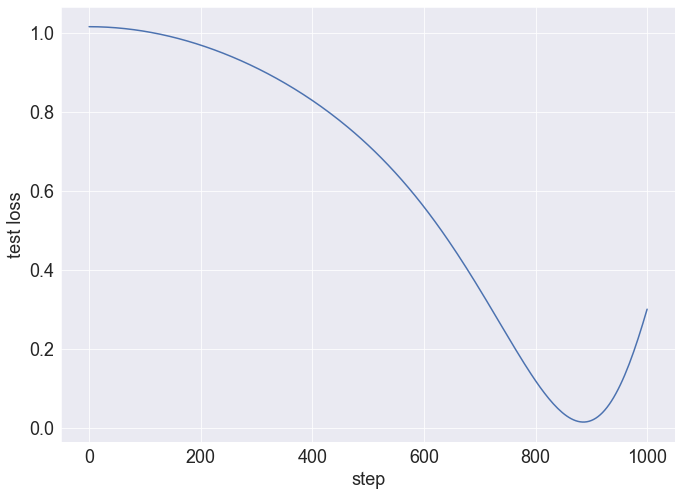

In [97]:
test_losses_m_df = test_losses_df.loc[test_losses_df.m == 1000]
plot_average_over_trials(test_losses_m_df, x='step', y='test loss', figsize=figsize)

## REMOVE BIAS NOW to see the difference !

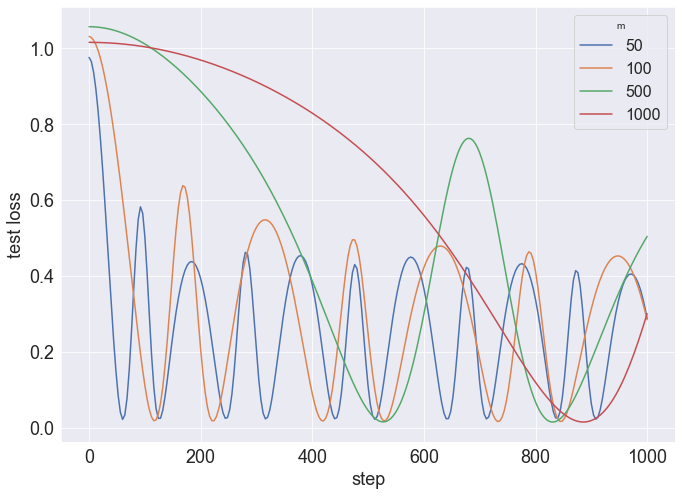

In [96]:
plot_average_over_trials(test_losses_df, x='step', y='test loss', hue='m', figsize=figsize)

In [100]:
dist_to_init_df = get_all_dist_to_init_df(dists_to_init_per_step)
dist_to_init_df.head(10)

,m,step,distance to init
0,50,0,0.000000
1,100,0,0.000000
2,500,0,0.000000
3,1000,0,0.000000
4,50,4,0.001085
5,100,4,0.000272
6,500,4,0.000009
7,1000,4,0.000002
8,50,8,0.013905
9,100,8,0.003508


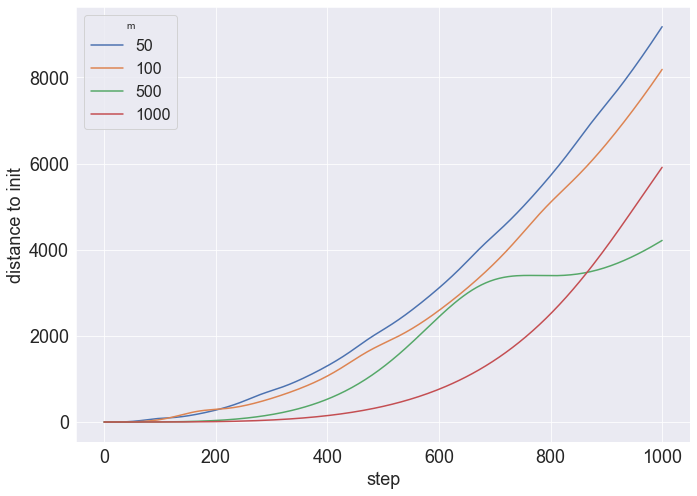

In [101]:
plot_average_over_trials(dist_to_init_df, x='step', y='distance to init', hue='m', figsize=figsize)

In [106]:
net

FCNetwork(
  (layers): Sequential(
    (0): WideLayer(
      (layer): Sequential(
        (0): Linear(in_features=50, out_features=1000, bias=True)
        (1): ReLU()
      )
    )
    (1): WideLayer(
      (layer): Sequential(
        (0): Linear(in_features=1000, out_features=1000, bias=False)
        (1): ReLU()
      )
    )
    (2): WideLayer(
      (layer): Linear(in_features=1000, out_features=1, bias=False)
    )
  )
)

In [109]:
layer = net.layers[0]
layer

WideLayer(
  (layer): Sequential(
    (0): Linear(in_features=50, out_features=1000, bias=True)
    (1): ReLU()
  )
)

In [110]:
linear = layer.layer[0]

In [111]:
layer_params = [param for param in layer.parameters()]
layer_params

[Parameter containing:
 tensor([[ 1.5208,  1.9641, -0.0085,  ...,  0.5136, -0.7037, -0.8555],
         [ 1.4381,  0.6354,  1.4891,  ...,  1.5724,  0.3184, -0.2018],
         [ 1.2877, -1.7820,  1.4576,  ..., -0.9049, -0.6817,  0.6849],
         ...,
         [-0.3986,  0.8049,  2.2106,  ...,  0.8494, -0.2334,  1.5832],
         [-0.5665, -0.0591, -1.0675,  ..., -1.2643, -0.9254,  1.4215],
         [ 0.8331, -1.1463,  1.3198,  ..., -1.4835,  1.2787, -1.0108]],
        requires_grad=True),
 Parameter containing:
 tensor([ 2.8240e-01,  6.3410e-01,  8.5214e-02, -1.1139e-01,  5.1067e-01,
         -5.5691e-02,  2.1000e-02,  9.5295e-02, -1.4607e-01,  9.5278e-02,
          2.2186e-01,  4.7629e-02, -2.5073e-01,  5.8633e-02, -5.1554e-02,
         -1.9429e-01,  2.1684e-01, -2.4431e-01, -1.6691e-01,  1.3664e-01,
          6.9899e-02, -8.3832e-02,  1.0861e-01, -4.0656e-01, -7.2803e-02,
          1.5651e-01, -7.0257e-03, -1.0684e-01,  1.2634e-01,  4.9477e-02,
         -1.0155e-01,  1.1801e-02,  2.99

In [112]:
layer_params_copy = deepcopy(layer_params)

In [134]:
i = 1.0
for param in layer_params:
    param.data = param.data.detach() + i * torch.ones_like(param.data)
    i = i + 1.0

In [126]:
t = torch.Tensor([1,2,3,4])

In [127]:
t = t + i

In [128]:
t

tensor([2., 3., 4., 5.])